These notebooks are taken from Udacity Reinforcement Nanodegree and modified accordingly.

The parameters are used from original [paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) but the network is trained very less due to hardware constraint. This environment can be trained in less time using some advance algorithms and preprocessing steps, check this [link](https://ai.stackexchange.com/questions/10203/dqn-stuck-at-suboptimal-policy-in-atari-pong-task) 

In [1]:
!nvidia-smi

Fri May 22 03:41:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import gym
import random
import numpy as np
from collections import deque,namedtuple
import matplotlib.pyplot as plt
import warnings
import cv2
import time

%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
warnings.filterwarnings("ignore")

In [5]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
env = gym.make('Pong-v4')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (210, 160, 3)
Number of actions:  6


In [7]:
print('Action space:',env.action_space)

Action space: Discrete(6)


In [0]:
frames = deque(maxlen =30)

In [0]:
# untrained agent
i = 0
for i in range(3):
    state = env.reset()
    while True:
        action = np.random.randint(0,env.action_space.n)
        #env.render()   #can't render in colab
        #time.sleep(.01)
        state, reward, done, _ = env.step(action)
        frames.append(state)
        if done:
            break 
env.close()

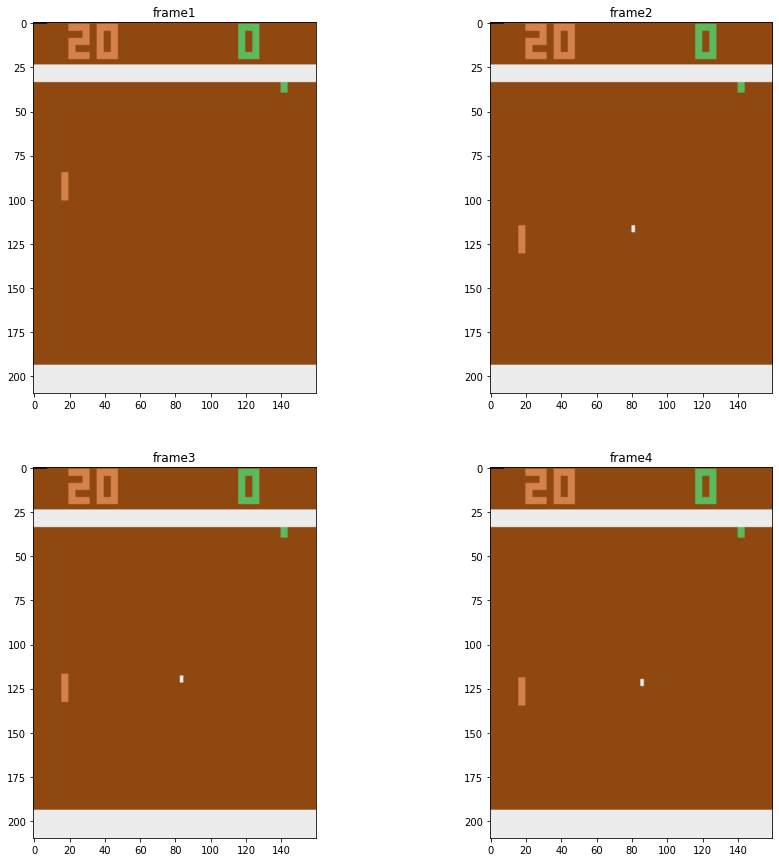

In [10]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(frames[0])
plt.title('frame1')
plt.subplot(222)
plt.imshow(frames[1])
plt.title('frame2')
plt.subplot(223)
plt.imshow(frames[2])
plt.title('frame3')
plt.subplot(224)
plt.imshow(frames[3])
plt.title('frame4')
plt.show()

In [0]:
def preprocess_image(image, targetwidth = 84, targetheight = 84):
    image = image[30:195,0:160,:].copy()
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image,(targetwidth,targetheight),cv2.INTER_AREA)
    
    return image
    

In [0]:
def get_state(previous_frames, current_frame):
    current_frame = preprocess_image(current_frame)
    if previous_frames is None:
        return np.dstack([current_frame,current_frame,current_frame,current_frame])
    else:
        a,b,c,d = np.dsplit(previous_frames,4)
        return np.dstack([current_frame,a,b,c])

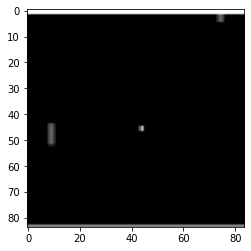

In [13]:
plt.imshow(preprocess_image(frames[2]),cmap = 'gray')

In [0]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, seed, input_channels = 4, action_size= 6):
        """Initialize parameters and build model.
        Params
        ======
            input_channels (int): Dimension of input channels of state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=input_channels,out_channels=32,kernel_size=8,stride=4)#20
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2) #9
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1) #7
        self.fc1 = nn.Linear(3136,512) #3136 
        self.fc2 = nn.Linear(512,action_size)

    def forward(self, state):
        """network that maps state -> action values."""
        
        batch_size = state.shape[0]
        #print(state.shape)
        x = self.conv1(state)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = F.relu(x)
        action_value = self.fc2(x)
        return action_value
        

In [0]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-5               # learning rate
UPDATE_EVERY = 8        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, input_channels, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            input_channels (int): Dimension of input channels of state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.input_channels = input_channels
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(seed=seed, input_channels= input_channels, action_size= action_size).to(device)
        self.qnetwork_target = QNetwork(seed=seed, input_channels= input_channels, action_size= action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        #loss
        self.criterion = torch.nn.MSELoss()
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def act(self, state, eps):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
            if eps is -1 then testing mode
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state = state.transpose(1,3)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if eps == -1:     #while testing
            return np.argmax(action_values.cpu().data.numpy())

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        self.optimizer.zero_grad()
        predictions = self.qnetwork_local(states)
        predictions = predictions.gather(1,actions)
        targets = rewards + gamma*(torch.max(self.qnetwork_target(next_states).detach(),1)[0]).view(-1,1)*(1-dones)

        #targets = rewards + gamma*(torch.max(self.qnetwork_target(next_states).detach(),1)[0]).view(-1,1)

        loss = self.criterion(predictions,targets)
        loss.backward()
        self.optimizer.step()



        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        # change shape according to pytorch conv2D
        states = states.transpose(1,3)
        next_states = next_states.transpose(1,3)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [0]:
agent = Agent(input_channels=4, action_size=env.action_space.n, seed=21)

In [0]:
#load previously trained model weights and scores
agent.qnetwork_local.load_state_dict(torch.load('weights/checkpoint_local_network.pth'))
agent.qnetwork_target.load_state_dict(torch.load('weights/checkpoint_target_network.pth'))
#scores = np.load('scores.npy')
#scores = list(scores)

In [0]:
# These parameters are modified as these model is trained in many steps. 
n_episodes=14000 
eps_start=0.110778
eps_end=0.1 
eps_decay=0.9998 
save_every = 500

Original parameters are:

- n_episodes=25000   (20000 seems good) 
- eps_start= 1
- eps_end=0.1 
- eps_decay=0.9998 
- save_every = 1000

In [20]:
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    frame = env.reset()
    state = get_state(previous_frames = None, current_frame = frame)
    score = 0
    while True:
        action = agent.act(state, eps)
        next_frame, reward, done, _ = env.step(action)
        next_state = get_state(state,next_frame)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most rec ent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if i_episode % save_every == 0:
        print('------------Saving Model------------')
        torch.save(agent.qnetwork_local.state_dict(),'weights/checkpoint_local_network.pth')
        torch.save(agent.qnetwork_target.state_dict(),'weights/checkpoint_target_network.pth')


Episode 100	Average Score: 7.63
Episode 200	Average Score: 8.60
Episode 300	Average Score: 8.09
Episode 400	Average Score: 9.15
Episode 500	Average Score: 9.18
------------Saving Model------------
Episode 600	Average Score: 9.35
Episode 700	Average Score: 9.14
Episode 800	Average Score: 9.73
Episode 900	Average Score: 10.09
Episode 1000	Average Score: 9.07
------------Saving Model------------
Episode 1100	Average Score: 9.60
Episode 1200	Average Score: 10.87
Episode 1300	Average Score: 9.12
Episode 1400	Average Score: 9.66
Episode 1500	Average Score: 8.87
------------Saving Model------------
Episode 1600	Average Score: 9.92
Episode 1700	Average Score: 9.65
Episode 1800	Average Score: 9.71
Episode 1900	Average Score: 9.90
Episode 2000	Average Score: 10.66
------------Saving Model------------
Episode 2100	Average Score: 10.49
Episode 2200	Average Score: 9.30
Episode 2300	Average Score: 9.51
Episode 2400	Average Score: 10.53
Episode 2500	Average Score: 10.34
------------Saving Model------

KeyboardInterrupt: ignored

I lost initial 7000 epsipode scores file, these are results after 7000 epoch.

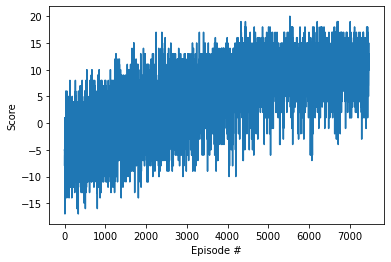

In [21]:
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [0]:
scores = np.array(scores)
np.save('scores.npy',scores)

watch and save output


In [ ]:
env = gym.wrappers.Monitor(env, './test_videos', force = True)
for i in range(3):
    frame = env.reset()
    state = get_state(previous_frames = None, current_frame = frame)
    score = 0
    while True:
        action = agent.act(state, eps= -1)
        env.render()
        time.sleep(.01)
        next_frame, reward, done, _ = env.step(action)
        state = get_state(state,next_frame)
        if done:
            break 
env.close()